In [1]:
# imports 

import tensorflow as tf
import os 
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, TimeDistributed, Input, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Concatenate, RepeatVector, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [59]:
# specify your directory where files are located 
# tensors loading

files_dir = '../data/processed/'
loaded_tensors = dict()
for file in [x for x in os.listdir(files_dir) if x.endswith("tfrecord")]:
    serialized_tensor = tf.io.read_file(os.path.join(files_dir,file))
    loaded_tensors[file] = tf.io.parse_tensor(serialized_tensor, out_type=tf.float32)

# coordinates loading 
df_coords = pd.read_excel(os.path.join(files_dir,"Coordinates_processed.xlsx"),sheet_name=['X','Y','TVD1','TVD2'],header=None)
df_X_Y = pd.DataFrame({col: list(zip(df_coords["X"][col], df_coords["Y"][col])) for col in  df_coords["X"].columns})
df_TVD = pd.DataFrame({col: list(zip(df_coords["TVD1"][col], df_coords["TVD2"][col])) for col in  df_coords["TVD1"].columns})

# time loading 
time_sequence = pd.read_csv(os.path.join(files_dir,"Dates_processed.csv"))

### Добавление приемистости 

In [60]:
raw_data_dir = '../data/'
df_injectivity = pd.read_excel(os.path.join(raw_data_dir,"raw_data.xlsx"),sheet_name=['приемистость'])
df_injectivity = df_injectivity["приемистость"].drop(columns=['Unnamed: 0'])

### Пример кода преобразования

In [34]:
import numpy as np

# Initial matrix values
matrix_values = [
    ['p22', 'p23', 'p24', 'p30', 'p31', 'p32'],
    ['p20', 'INJE3', 'p21', 'p28', 'INJE4', 'p29'],
    ['p17', 'p18', 'p19', 'p25', 'p26', 'p27'],
    ['p6', 'p7', 'p8', 'p14', 'p15', 'p16'],
    ['p4', 'INJE1', 'p5', 'p12', 'INJE2', 'p13'],
    ['p1', 'p2', 'p3', 'p9', 'p10', 'p11']
]

# Convert to numpy array and repeat
matrix_array = np.array(matrix_values)
repeated_matrix = np.tile(matrix_array, (121, 1, 1))

# Create a mask to remove the specific elements
mask = np.ones(repeated_matrix.shape, dtype=bool)
mask[:, 1, 1] = False
mask[:, 1, 4] = False
mask[:, 4, 1] = False
mask[:, 4, 4] = False  # This seems to be a repeat; ensure this element is removed

# Apply the mask and reshape the array
filtered_array = repeated_matrix[mask].reshape(121, 4, 8)

# Display the shape to verify
print(filtered_array.shape)

(121, 4, 8)


In [35]:
filtered_array[0]

array([['p22', 'p23', 'p24', 'p30', 'p31', 'p32', 'p20', 'p21'],
       ['p28', 'p29', 'p17', 'p18', 'p19', 'p25', 'p26', 'p27'],
       ['p6', 'p7', 'p8', 'p14', 'p15', 'p16', 'p4', 'p5'],
       ['p12', 'p13', 'p1', 'p2', 'p3', 'p9', 'p10', 'p11']], dtype='<U5')

### Преобразование массивов (121,6,6) в (121,4,8)

In [61]:
oil_data = loaded_tensors['debit_neft_series.tfrecord'].numpy()
water_data = loaded_tensors['debit_water_series.tfrecord'].numpy()
reservoir_pressure_data = loaded_tensors['debit_plast_pressure_series.tfrecord'].numpy()
bottomhole_pressure_data = loaded_tensors['debit_zaboy_pressure_series.tfrecord'].numpy()

# Create a mask to remove the specific elements
mask = np.ones(oil_data.shape, dtype=bool)
mask[:, 1, 1] = False
mask[:, 1, 4] = False
mask[:, 4, 1] = False
mask[:, 4, 4] = False  # This seems to be a repeat; ensure this element is removed

# Apply the mask and reshape the array
loaded_tensors['debit_neft_series.tfrecord'] = tf.convert_to_tensor(oil_data[mask].reshape(121, 4, 8), dtype=tf.float32)
loaded_tensors['debit_water_series.tfrecord'] = tf.convert_to_tensor(water_data[mask].reshape(121, 4, 8), dtype=tf.float32)
loaded_tensors['debit_plast_pressure_series.tfrecord'] = tf.convert_to_tensor(reservoir_pressure_data[mask].reshape(121, 4, 8), dtype=tf.float32)
loaded_tensors['debit_zaboy_pressure_series.tfrecord'] =tf.convert_to_tensor(bottomhole_pressure_data[mask].reshape(121, 4, 8), dtype=tf.float32)

# reshape coords and TVD
df_X_Y = pd.DataFrame(df_X_Y.values[mask[0]].reshape(4, 8))
df_TVD = pd.DataFrame(df_TVD.values[mask[0]].reshape(4, 8))

### Пример кода преобразования

In [62]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Concatenate, RepeatVector, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Parameters
total_time_steps = 121
train_time_steps = 84
test_time_steps = total_time_steps - train_time_steps
map_height = 4
map_width = 8
batch_size = 1
dropout_rate = 0.3

# Function to create CNN layers for input tensors
def create_cnn(input_tensor):
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(input_tensor)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)
    return x

# Input tensors for training model
inputs_train = {
    'oil': Input(shape=(train_time_steps, map_height, map_width, 1), name='input_oil'),
    'water': Input(shape=(train_time_steps, map_height, map_width, 1), name='input_water'),
    'reservoir_pressure': Input(shape=(train_time_steps, map_height, map_width, 1), name='input_reservoir_pressure'),
    'bottomhole_pressure': Input(shape=(train_time_steps, map_height, map_width, 1), name='input_bottomhole_pressure'),
    'coordinates': Input(shape=(map_height, map_width, 2), name='input_coordinates'),
    'tvd': Input(shape=(map_height, map_width, 2), name='input_tvd'),
}

# Input tensors for testing model
inputs_test = {
    'oil': Input(shape=(test_time_steps, map_height, map_width, 1), name='input_oil'),
    'water': Input(shape=(test_time_steps, map_height, map_width, 1), name='input_water'),
    'reservoir_pressure': Input(shape=(test_time_steps, map_height, map_width, 1), name='input_reservoir_pressure'),
    'bottomhole_pressure': Input(shape=(test_time_steps, map_height, map_width, 1), name='input_bottomhole_pressure'),
    'coordinates': Input(shape=(map_height, map_width, 2), name='input_coordinates'),
    'tvd': Input(shape=(map_height, map_width, 2), name='input_tvd')
}

# Creating CNN layers for training and testing
cnn_train = {name: create_cnn(tensor) for name, tensor in inputs_train.items() if name not in ['coordinates', 'tvd']}
cnn_test = {name: create_cnn(tensor) for name, tensor in inputs_test.items() if name not in ['coordinates', 'tvd']}

# Flatten and repeat coordinates and TVD for training
flattened_coordinates_train = Flatten()(inputs_train['coordinates'])
repeated_coordinates_train = RepeatVector(train_time_steps)(flattened_coordinates_train)
flattened_tvd_train = Flatten()(inputs_train['tvd'])
repeated_tvd_train = RepeatVector(train_time_steps)(flattened_tvd_train)

# Flatten and repeat coordinates and TVD for testing
flattened_coordinates_test = Flatten()(inputs_test['coordinates'])
repeated_coordinates_test = RepeatVector(test_time_steps)(flattened_coordinates_test)
flattened_tvd_test = Flatten()(inputs_test['tvd'])
repeated_tvd_test = RepeatVector(test_time_steps)(flattened_tvd_test)

# Concatenating all inputs for training, including injectivity
merged_train = Concatenate(axis=-1)(list(cnn_train.values()))
flattened_merged_train = TimeDistributed(Flatten())(merged_train)
combined_train = Concatenate(axis=-1)([flattened_merged_train, repeated_coordinates_train, repeated_tvd_train])
# Example of adding more layers to the LSTM model
lstm_out_train = LSTM(128, return_sequences=True)(combined_train)
lstm_out_train = LSTM(64, return_sequences=False)(lstm_out_train)
dropout_train = Dropout(dropout_rate)(lstm_out_train)
dense_1_train = Dense(128, activation='relu')(dropout_train)
dropout_train_2 = Dropout(dropout_rate)(dense_1_train)
dense_2_train = Dense(72, activation='relu')(dropout_train_2)
output_train = Dense(map_height * map_width, activation='linear', name='output')(dense_2_train)
output_train = Reshape((map_height, map_width))(output_train)

# Training model
model_train = Model(inputs=list(inputs_train.values()), outputs=output_train)
model_train.compile(optimizer='adam', loss='mse')

# Concatenating all inputs for testing, including injectivity
merged_test = Concatenate(axis=-1)(list(cnn_test.values()))
flattened_merged_test = TimeDistributed(Flatten())(merged_test)
combined_test = Concatenate(axis=-1)([flattened_merged_test, repeated_coordinates_test, repeated_tvd_test])
lstm_out_test = LSTM(128, return_sequences=False)(combined_test)
dropout_test = Dropout(dropout_rate)(lstm_out_test)
dense_1_test = Dense(128, activation='relu')(dropout_test)
dropout_test_2 = Dropout(dropout_rate)(dense_1_test)
dense_2_test = Dense(72, activation='relu')(dropout_test_2)
output_test = Dense(map_height * map_width, activation='linear', name='output')(dense_2_test)
output_test = Reshape((map_height, map_width))(output_test)

# Testing model
model_test = Model(inputs=list(inputs_test.values()), outputs=output_test)
model_test.compile(optimizer='adam', loss='mse')

# Load and preprocess data (Assuming loaded_tensors and injectivity_array are already defined)
oil_data = np.expand_dims(loaded_tensors['debit_neft_series.tfrecord'].numpy(), axis=-1)
water_data = np.expand_dims(loaded_tensors['debit_water_series.tfrecord'].numpy(), axis=-1)
reservoir_pressure_data = np.expand_dims(loaded_tensors['debit_plast_pressure_series.tfrecord'].numpy(), axis=-1)
bottomhole_pressure_data = np.expand_dims(loaded_tensors['debit_zaboy_pressure_series.tfrecord'].numpy(), axis=-1)

# Transforming df_X_Y and df_TVD to numpy arrays of required shape
coordinates_data = np.array(df_X_Y.applymap(lambda x: list(x)).values.tolist()).reshape((batch_size, map_height, map_width, 2))
tvd_data = np.array(df_TVD.applymap(lambda x: list(x)).values.tolist()).reshape((batch_size, map_height, map_width, 2))

# Ensuring data shapes match expected shape
oil_data = oil_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
water_data = water_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
reservoir_pressure_data = reservoir_pressure_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
bottomhole_pressure_data = bottomhole_pressure_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))

# Проверка на наличие пропусков и заполнение нулями или средними значениями
oil_data = np.nan_to_num(oil_data)
water_data = np.nan_to_num(water_data)
reservoir_pressure_data = np.nan_to_num(reservoir_pressure_data)
bottomhole_pressure_data = np.nan_to_num(bottomhole_pressure_data)

# Масштабирование данных
scalers = {}
for data_name, data in zip(['oil', 'water', 'reservoir_pressure', 'bottomhole_pressure'],
                           [oil_data, water_data, reservoir_pressure_data, bottomhole_pressure_data]):
    scalers[data_name] = MinMaxScaler()
    data_reshaped = data.reshape(-1, data.shape[-1])
    scaled_data = scalers[data_name].fit_transform(data_reshaped)
    data[:] = scaled_data.reshape(data.shape)

# Splitting data into training and test sets
oil_train, oil_test = oil_data[:, :train_time_steps], oil_data[:, train_time_steps:]
water_train, water_test = water_data[:, :train_time_steps], water_data[:, train_time_steps:]
reservoir_pressure_train, reservoir_pressure_test = reservoir_pressure_data[:, :train_time_steps], reservoir_pressure_data[:, train_time_steps:]
bottomhole_pressure_train, bottomhole_pressure_test = bottomhole_pressure_data[:, :train_time_steps], bottomhole_pressure_data[:, train_time_steps:]

# Define output for training and testing
output_train_data = oil_data[:, :train_time_steps, :, :, 0].reshape((batch_size, train_time_steps, map_height, map_width))
output_test_data = oil_data[:, train_time_steps:, :, :, 0].reshape((batch_size, test_time_steps, map_height, map_width))

# Adding EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Training the model with validation
history = model_train.fit(
    [oil_train, water_train, reservoir_pressure_train, bottomhole_pressure_train, coordinates_data, tvd_data],
    output_train_data,
    epochs=500,
    callbacks=[early_stopping]
)


Epoch 1/1000


C:\Users\safae\AppData\Local\Temp\ipykernel_39812\4055068915.py:103: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  coordinates_data = np.array(df_X_Y.applymap(lambda x: list(x)).values.tolist()).reshape((batch_size, map_height, map_width, 2))
C:\Users\safae\AppData\Local\Temp\ipykernel_39812\4055068915.py:104: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tvd_data = np.array(df_TVD.applymap(lambda x: list(x)).values.tolist()).reshape((batch_size, map_height, map_width, 2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - loss: 0.0935
Epoch 2/1000


c:\Users\safae\anaconda3\envs\lstm_test\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 0.0950
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.0659
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 0.0839
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 0.0630
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.0727
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.0608
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.0543
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.0597
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0561
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.0572
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.0535
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.0565
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 0.0488
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.0490
Epoch 16/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.0536
E

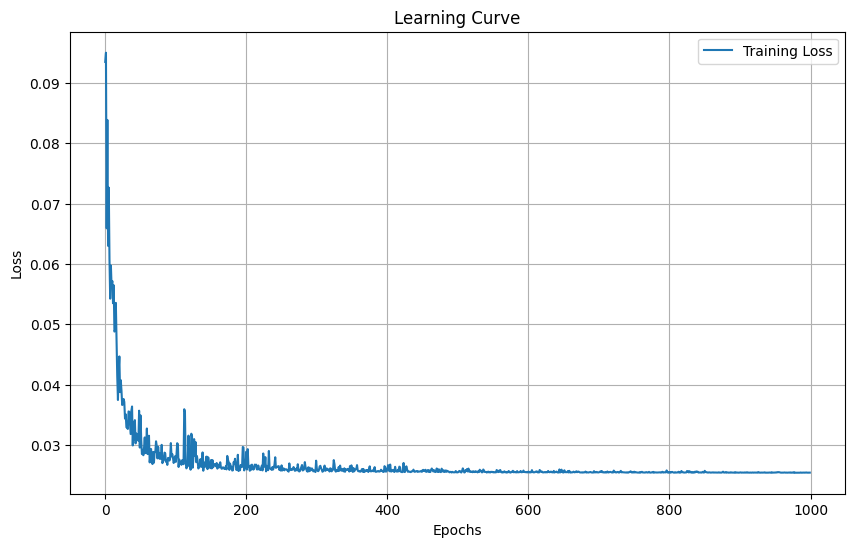

In [63]:
import matplotlib.pyplot as plt

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()
